In [ ]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    auc,
)

from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate
import pydot
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
CLEAN_DATA_FOLDER = "/content/drive/MyDrive/GWAR/All_files/"
MODEL_DATA_FOLDER = "/content/drive/MyDrive/GWAR/All_files/Model"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and prepare training data
train_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER,"train.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    }
)

# Convert lists into train TensorFlow ragged tensors
train_X_0 = tf.ragged.constant(train_df["question1"].tolist())
train_X_1 = tf.ragged.constant(train_df["question2"].tolist())
train_Y = tf.ragged.constant(train_df["is_duplicate"].tolist(), dtype=tf.float32)

In [ ]:
test_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "test.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    }
)

# Convert lists into test TensorFlow ragged tensors
test_X_0 = tf.ragged.constant(test_df["question1"].tolist())
test_X_1 = tf.ragged.constant(test_df["question2"].tolist())
test_Y = tf.ragged.constant(test_df["is_duplicate"].tolist(), dtype=tf.float32)

In [ ]:
validation_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "validation.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    },
)
# Convert lists into validation TensorFlow ragged tensors
validation_X_0 = tf.ragged.constant(validation_df["question1"].tolist())
validation_X_1 = tf.ragged.constant(validation_df["question2"].tolist())
validation_Y = tf.ragged.constant(validation_df["is_duplicate"].tolist(), dtype=tf.float32)

In [ ]:
# Setting best or common parameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 50

In [ ]:
# Function to pad inputs for uniformity
def pad_inputs(inputs, outputs):
    return (
        (inputs[0].to_tensor(default_value=0), inputs[1].to_tensor(default_value=0)),
        tf.expand_dims(outputs, axis=-1),
    )

def get_embedding_layer(embed_name="fasttext", embed_dim=100):
    embedding_matrix = np.load(os.path.join(CLEAN_DATA_FOLDER, f"{embed_name}.{embed_dim}d.embeddings.npy"))
    embedding_layer = keras.layers.Embedding(embedding_matrix.shape[0], embed_dim, name=f"{embed_name}")
    embedding_layer.build((1,))
    embedding_layer.trainable = False
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

In [ ]:
# Prepare dataset for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices(((train_X_0, train_X_1), train_Y))
train_dataset = train_dataset.shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_X_0, validation_X_1), validation_Y))
validation_dataset = validation_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((test_X_0, test_X_1), test_Y))
test_dataset = test_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Model creation function for GRU
def create_gru_model(embed_name="fasttext", embed_dim=100):
    question1 = Input(shape=(None,), dtype='int32', name="question1")
    question2 = Input(shape=(None,), dtype='int32', name="question2")

    embedding_layer = get_embedding_layer(embed_name, embed_dim)

    q1_embed = embedding_layer(question1)
    q2_embed = embedding_layer(question2)

    gru_layer = keras.layers.GRU(128, return_sequences=False)
    q1_encoded = gru_layer(q1_embed)
    q2_encoded = gru_layer(q2_embed)

    concatenated = keras.layers.concatenate([q1_encoded, q2_encoded])
    dense1 = keras.layers.Dense(64, activation='relu')(concatenated)
    output = keras.layers.Dense(1, activation='sigmoid')(dense1)

    model = keras.Model(inputs=[question1, question2], outputs=output)
    return model

# Create GRU model
model = create_gru_model("fasttext", 100)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ question1 (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question2 (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fasttext (Embedding)      │ (None, None, 100)      │     11,280,200 │ question1[0][0],       │
│                           │                        │                │ question2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 128)            │         88,320 │ fasttext[0][0],        │
│                           │                        │                │ fasttext[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256)            │              0 │ gru[0][0], gru[1][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         16,448 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,385,033 (43.43 MB)

 Trainable params: 104,833 (409.50 KB)

 Non-trainable params: 11,280,200 (43.03 MB)

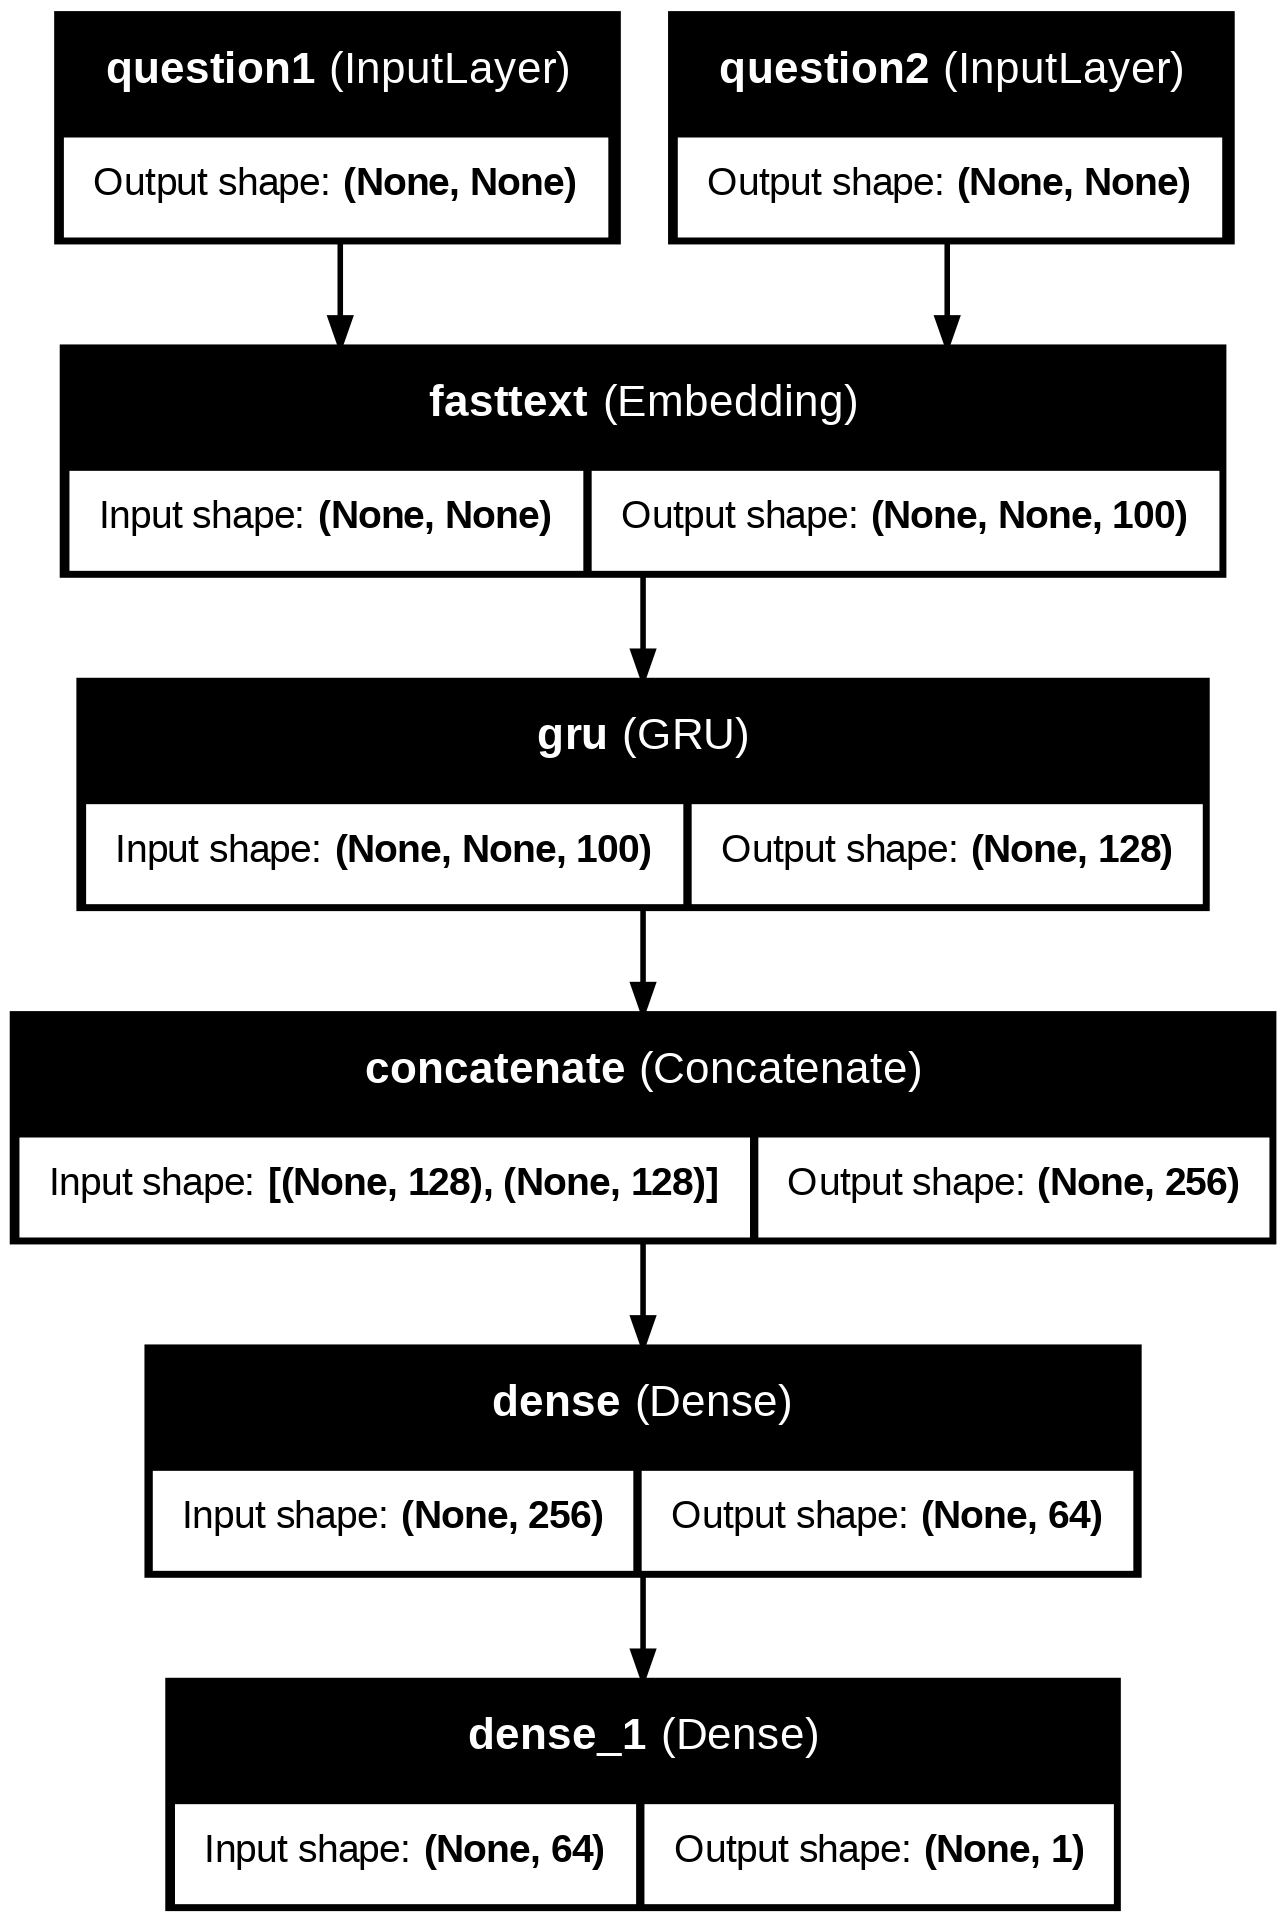

In [ ]:
keras.utils.plot_model(
    model,
    to_file=os.path.join(MODEL_DATA_FOLDER, "GPU_model_fasttext.png"),
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
# Model compilation
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

# Model training
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True)]
)

# Saving the model
model.save(os.path.join(MODEL_DATA_FOLDER, "gru_fasttext_model.keras"))

Epoch 1/50
6477/6477 ━━━━━━━━━━━━━━━━━━━━ 760s 117ms/step - auc_2: 0.7659 - binary_accuracy: 0.6944 - loss: 0.5733 - val_auc_2: 0.7968 - val_binary_accuracy: 0.7132 - val_loss: 0.5493
Epoch 2/50
6477/6477 ━━━━━━━━━━━━━━━━━━━━ 765s 111ms/step - auc_2: 0.8448 - binary_accuracy: 0.7605 - loss: 0.4849 - val_auc_2: 0.8326 - val_binary_accuracy: 0.7547 - val_loss: 0.4914
Epoch 3/50
6477/6477 ━━━━━━━━━━━━━━━━━━━━ 722s 108ms/step - auc_2: 0.8758 - binary_accuracy: 0.7893 - loss: 0.4390 - val_auc_2: 0.8543 - val_binary_accuracy: 0.7804 - val_loss: 0.4570
Epoch 4/50
6477/6477 ━━━━━━━━━━━━━━━━━━━━ 760s 111ms/step - auc_2: 0.8944 - binary_accuracy: 0.8084 - loss: 0.4071 - val_auc_2: 0.8625 - val_binary_accuracy: 0.7882 - val_loss: 0.4441
Epoch 5/50
6477/6477 ━━━━━━━━━━━━━━━━━━━━ 759s 113ms/step - auc_2: 0.9069 - binary_accuracy: 0.8214 - loss: 0.3837 - val_auc_2: 0.8702 - val_binary_accuracy: 0.7944 - val_loss: 0.4346
Epoch 6/50
6477/6477 ━━━━━━━━━━━━━━━━━━━━ 716s 109ms/step - auc_2: 0.9174 - bina

In [ ]:
class QuoraQuestionPairDataset(keras.utils.PyDataset):
    def __init__(self, x, y, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.x = x
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.y) / self.batch_size)

    def __getitem__(self, idx):
        batch_x_0 = self.x[0][idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x_1 = self.x[1][idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x_0 = keras.utils.pad_sequences(batch_x_0, padding='post')
        batch_x_1 = keras.utils.pad_sequences(batch_x_1, padding='post')
        batch_y = np.expand_dims(np.asarray(batch_y), axis=-1)
        return (batch_x_0, batch_x_1), batch_y

Data Structure to store metrics

In [ ]:
validation_metrics = {
    "Accuracy": {},
    "Precision": {},
    "Recall": {},
    "F1": {},
    "ROC AUC": {},
    "PR AUC": {}
}

In [ ]:
model.load_weights(os.path.join(MODEL_DATA_FOLDER, "gru_fasttext_model.keras"))

In [ ]:
model_name = "GRU (Fasttext)"

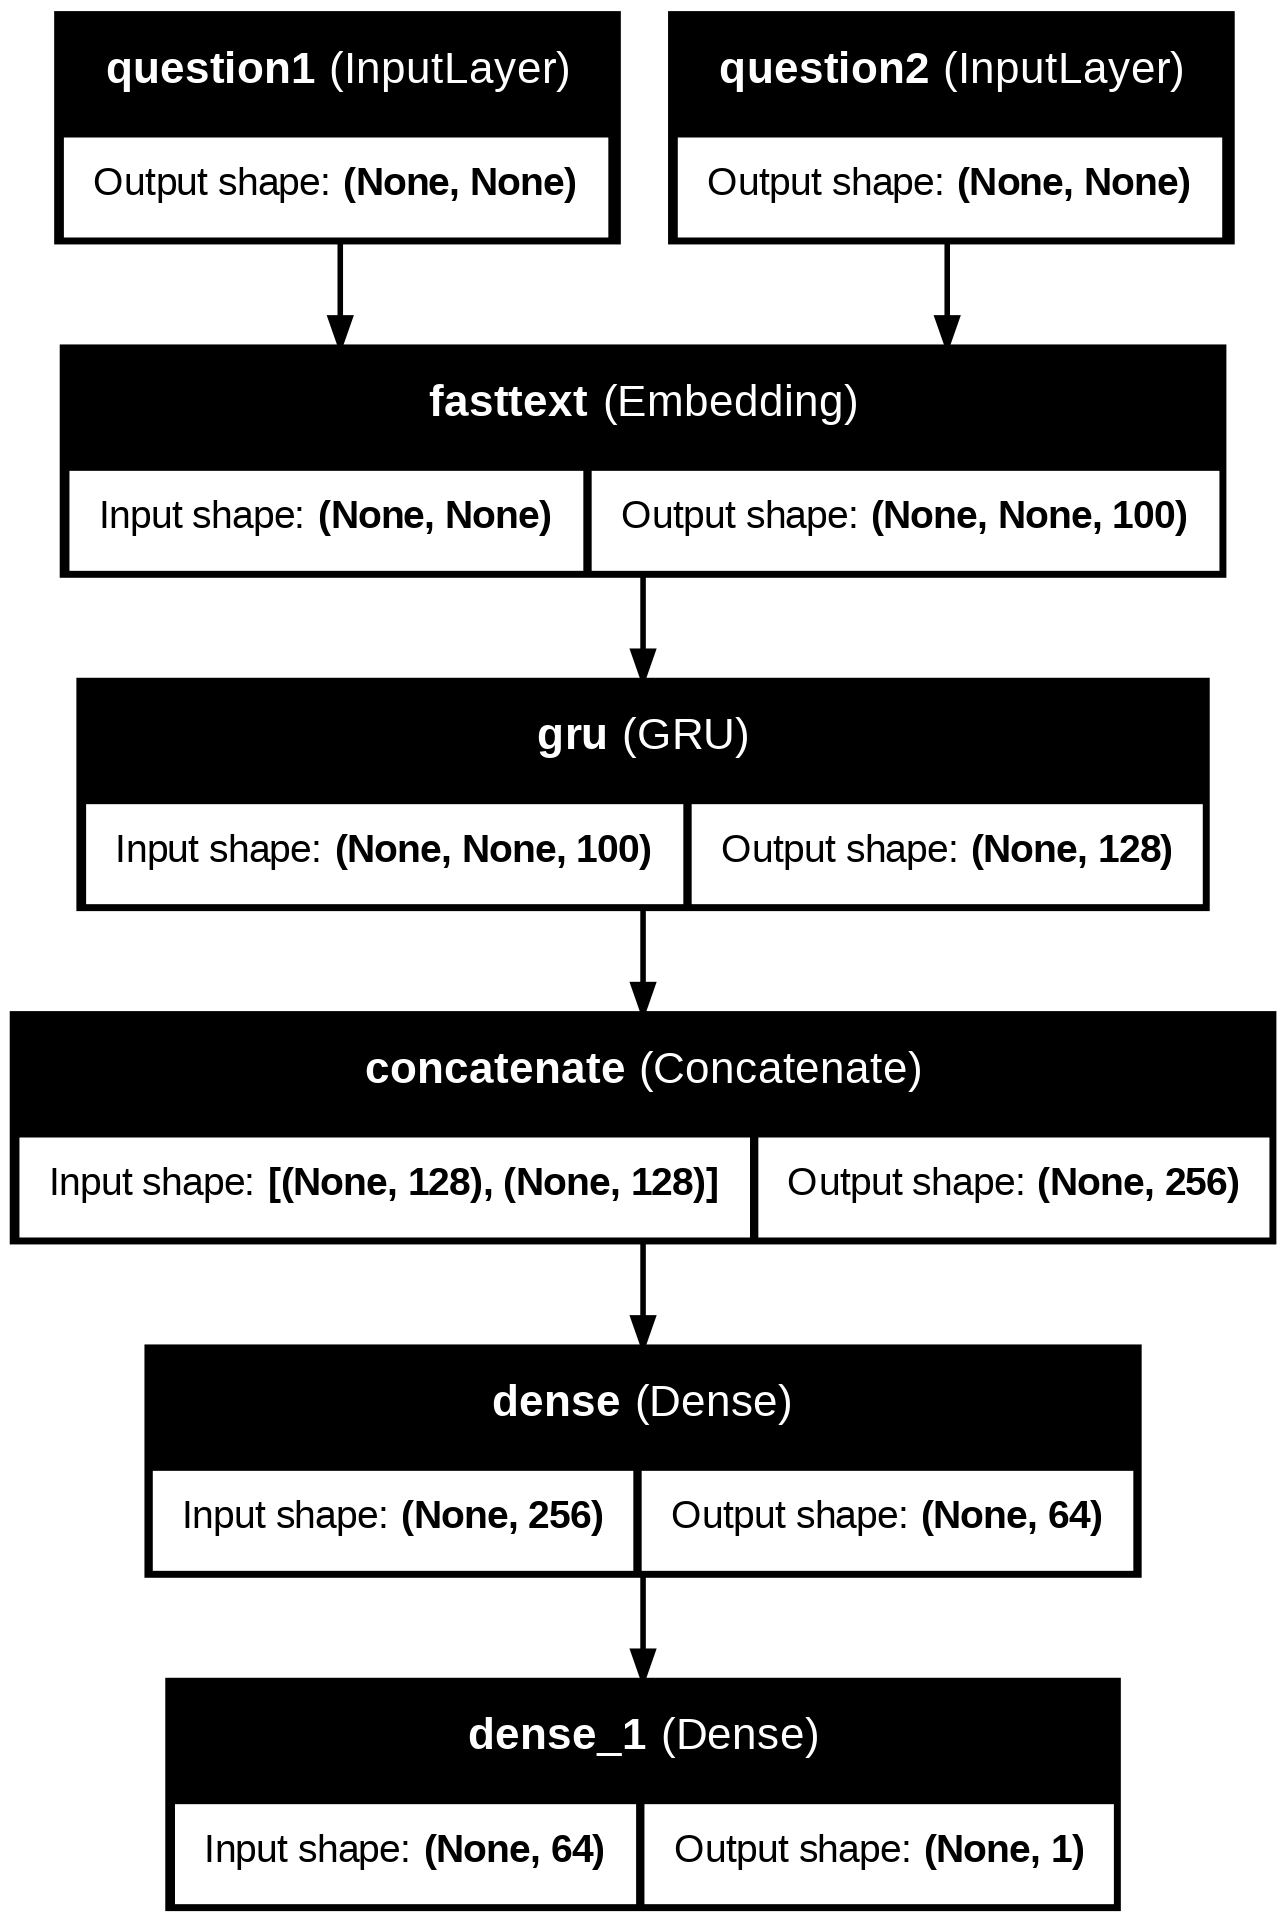

In [ ]:
keras.utils.plot_model(
    model,
    to_file=os.path.join(MODEL_DATA_FOLDER, f"test_model.png"),
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
validation_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "validation.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    },
)
validation_dataset = QuoraQuestionPairDataset(
    x=(validation_df["question1"].tolist(), validation_df["question2"].tolist()),
    y=validation_df["is_duplicate"].tolist(),
    batch_size=256,
)
validation_y_pred = model.predict(validation_dataset)
validation_results_df = pd.DataFrame(
    {
        "y_true": validation_df["is_duplicate"].tolist(),
        "y_pred": validation_y_pred.round().astype(int).squeeze().tolist(),
        "y_score": validation_y_pred.squeeze().tolist(),
    }
)

158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


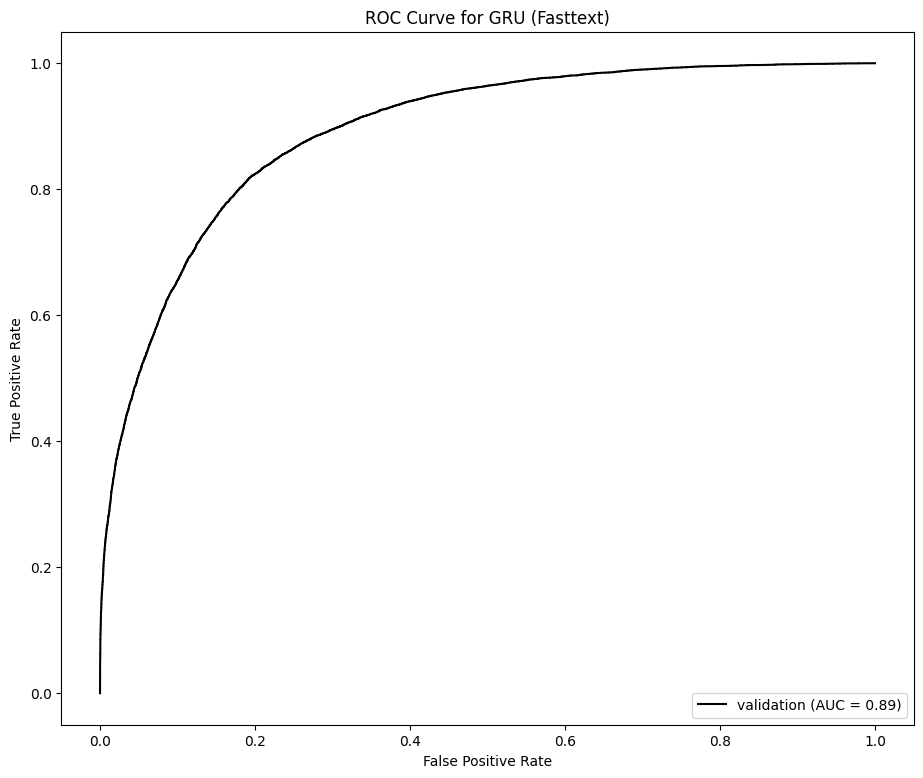

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(11, 9))
ax.set_title(f"ROC Curve for {model_name}")
fpr, tpr, thresholds = roc_curve(
    validation_results_df["y_true"], validation_results_df["y_score"], pos_label=1
)
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name="validation"
)
_ = display.plot(ax=ax, color="black")

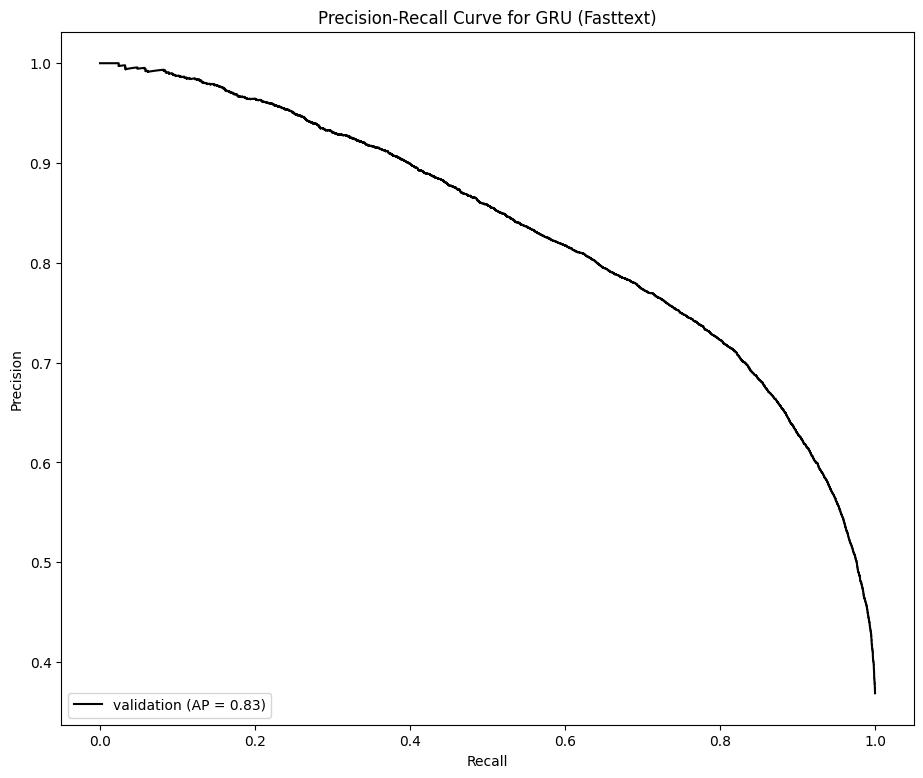

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(11, 9))
ax.set_title(f"Precision-Recall Curve for {model_name}")
precision, recall, _ = precision_recall_curve(
    validation_results_df["y_true"], validation_results_df["y_score"], pos_label=1
)
display = PrecisionRecallDisplay(
    precision=precision,
    recall=recall,
    average_precision=average_precision_score(
        validation_results_df["y_true"], validation_results_df["y_score"]
    ),
    estimator_name="validation",
)
_ = display.plot(ax=ax, color="black")

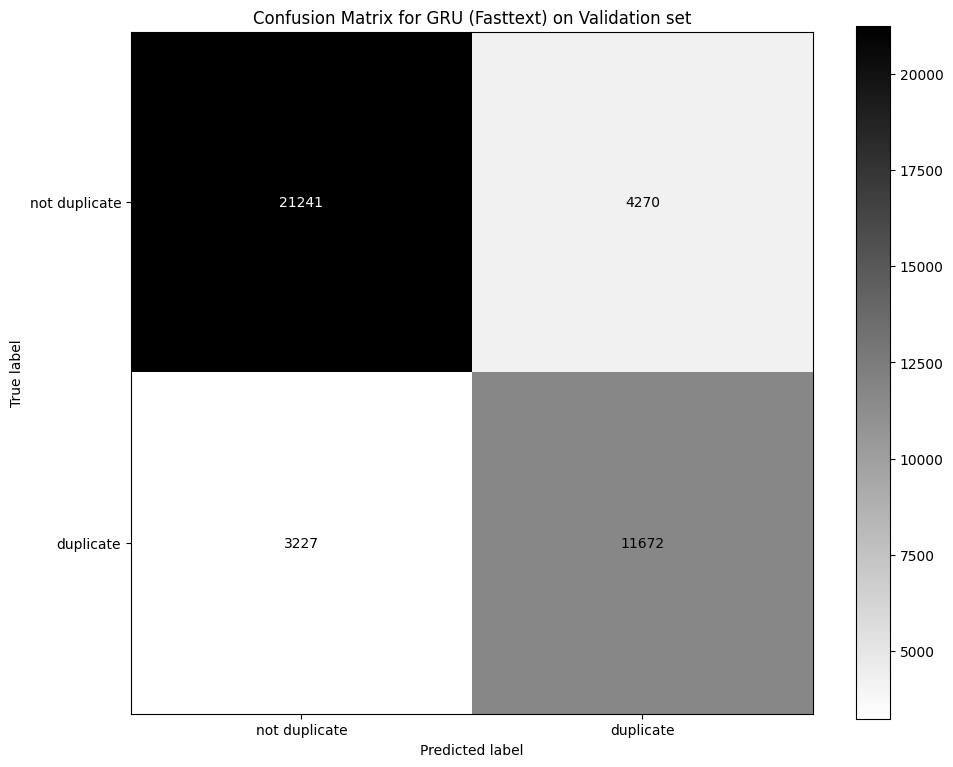

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(11, 9))
ax.set_title(f"Confusion Matrix for {model_name} on Validation set")
display = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        validation_results_df["y_true"], validation_results_df["y_pred"]
    ),
    display_labels=("not duplicate", "duplicate"),
)
_ = display.plot(ax=ax, cmap="binary")

In [ ]:
accuracy = accuracy_score(validation_results_df["y_true"], validation_results_df["y_pred"])
precision = precision_score(validation_results_df["y_true"], validation_results_df["y_pred"])
recall = recall_score(validation_results_df["y_true"], validation_results_df["y_pred"])
f1 = f1_score(validation_results_df["y_true"], validation_results_df["y_pred"])
auc_roc = roc_auc_score(validation_results_df["y_true"], validation_results_df["y_score"])
pr, re, _ = precision_recall_curve(
    validation_results_df["y_true"], validation_results_df["y_score"], pos_label=1
)
auc_pr = auc(re, pr)
validation_metrics["Accuracy"][model_name] = accuracy
validation_metrics["Precision"][model_name] = precision
validation_metrics["Recall"][model_name] = recall
validation_metrics["F1"][model_name] = f1
validation_metrics["ROC AUC"][model_name] = auc_roc
validation_metrics["PR AUC"][model_name] = auc_pr
pd.DataFrame(validation_metrics)
pd.DataFrame(validation_metrics).to_csv("temp_results.csv", index_label="Model")
pd.DataFrame(validation_metrics)

,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC
GRU (Fasttext),0.814477,0.732154,0.783408,0.756914,0.891147,0.832469
